In [1]:
%pylab inline

import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import keras as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16, \
    preprocess_input
from keras.layers import Dense, InputLayer, \
    Convolution2D, MaxPooling2D, Flatten,   \
    Dropout, BatchNormalization

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# To stop potential randomness
seed = 42
rng = np.random.RandomState(seed)

In [3]:
data = pd.read_csv('../datasets/emergency_classification/emergency_classification.csv')

In [4]:
emergency_vehicles = glob('../datasets/emergency_classification/images/Emergency/*.jpg')
nonemergency_vehicles = glob('../datasets/emergency_classification/images/Non-Emergency/*.jpg')

In [5]:
len(emergency_vehicles), len(nonemergency_vehicles)

(991, 1361)

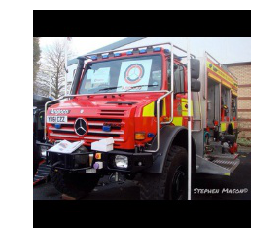

In [6]:
img_name = rng.choice(emergency_vehicles)

img = imread(img_name)

pylab.imshow(img)
pylab.axis('off')
pylab.show()

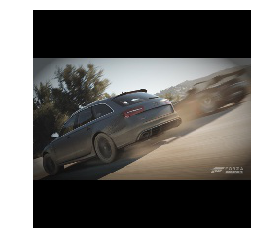

In [7]:
img_name = rng.choice(nonemergency_vehicles)

img = imread(img_name)

pylab.imshow(img)
pylab.axis('off')
pylab.show()

In [8]:
images = []
for img_loc in data.images:
    img = image.load_img('../datasets/emergency_classification/' + img_loc)
    img = image.img_to_array(img)
    images.append(img)
    
images=np.array(images)

In [9]:
images.shape

(2352, 224, 224, 3)

In [10]:
train_x = images / images.max()
train_y = data.emergency_or_not.values

In [11]:
X_train, X_valid, Y_train, Y_valid=train_test_split(train_x,train_y,test_size=0.3, random_state=42)

In [12]:
model = Sequential([
 InputLayer(input_shape=(224, 224, 3)),

 Convolution2D(32, (5, 5), activation='relu'),
 BatchNormalization(),
 MaxPooling2D(pool_size=2),

 Convolution2D(64, (5, 5), activation='relu'),
 BatchNormalization(),
 MaxPooling2D(pool_size=2),

 Convolution2D(128, (5, 5), activation='relu'),
 BatchNormalization(),
 MaxPooling2D(pool_size=2),
    
 Convolution2D(256, (5, 5), activation='relu'),
 BatchNormalization(),
 MaxPooling2D(pool_size=2),
    
 Convolution2D(512, (5, 5), activation='relu'),
 BatchNormalization(),
 MaxPooling2D(pool_size=6),

 Flatten(),

 Dense(units=512, activation='sigmoid'),
 Dropout(0.5),
    
 Dense(units=1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 64)      51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 106, 106, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 128)       204928    
__________

In [14]:
datagen = image.ImageDataGenerator(
    width_shift_range = 0.2,
    horizontal_flip = True
)

In [15]:
final_weights_path = 'model_weights.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [16]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=256),epochs=60,validation_data=(X_valid,Y_valid), callbacks=callbacks_list, shuffle=False, workers=5, use_multiprocessing=True)

Epoch 1/60
7/7 [==============================] - 15s 2s/step - loss: 0.8056 - acc: 0.6454 - val_loss: 1.3396 - val_acc: 0.4391

Epoch 00001: val_loss improved from inf to 1.33956, saving model to model_weights.h5
Epoch 2/60
7/7 [==============================] - 7s 940ms/step - loss: 0.5140 - acc: 0.7447 - val_loss: 1.1896 - val_acc: 0.4589

Epoch 00002: val_loss improved from 1.33956 to 1.18959, saving model to model_weights.h5
Epoch 3/60
7/7 [==============================] - 8s 1s/step - loss: 0.4455 - acc: 0.7864 - val_loss: 0.8424 - val_acc: 0.6232

Epoch 00003: val_loss improved from 1.18959 to 0.84239, saving model to model_weights.h5
Epoch 4/60
7/7 [==============================] - 8s 1s/step - loss: 0.3918 - acc: 0.8268 - val_loss: 0.6679 - val_acc: 0.6700

Epoch 00004: val_loss improved from 0.84239 to 0.66793, saving model to model_weights.h5
Epoch 5/60
7/7 [==============================] - 8s 1s/step - loss: 0.3517 - acc: 0.8437 - val_loss: 1.3711 - val_acc: 0.4901

Epoc

In [24]:
model.load_weights(final_weights_path)

In [25]:
predictions = model.predict_classes(X_valid).ravel()
prediction_probabilities = model.predict(X_valid).ravel()
all_vehicles = np.array(emergency_vehicles + nonemergency_vehicles)

_, valid_vehicles, _, valid_y = train_test_split(all_vehicles,train_y,test_size=0.3, random_state=42)

99 % sure that it is emergency


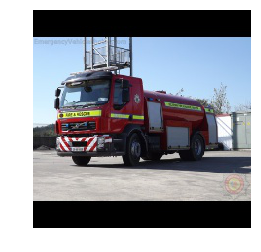

In [26]:
correct_predictions = valid_vehicles[predictions == Y_valid]

index = rng.choice(range(len(correct_predictions)))
img_name = correct_predictions[index]


prob = (prediction_probabilities[predictions == Y_valid] * 100).astype(int)[index]

img = imread(img_name)

print(prob , '% sure that it is emergency')
pylab.imshow(img)
pylab.axis('off')
pylab.show()

34 % sure that it is emergency


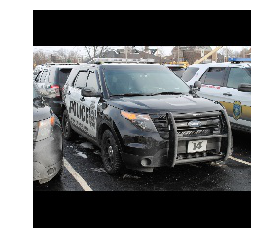

In [27]:
incorrect_predictions = valid_vehicles[predictions != Y_valid]
index = rng.choice(range(len(incorrect_predictions)))
img_name = incorrect_predictions[index]


prob = (prediction_probabilities[predictions != Y_valid] * 100).astype(int)[index]

img = imread(img_name)

print(prob , '% sure that it is emergency')
pylab.imshow(img)
pylab.axis('off')
pylab.show()

In [28]:
print(classification_report(predictions, Y_valid))

             precision    recall  f1-score   support

          0       0.91      0.90      0.90       402
          1       0.87      0.88      0.88       304

avg / total       0.89      0.89      0.89       706



In [29]:
tn, fp, fn, tp = confusion_matrix(predictions, Y_valid).ravel()

In [30]:
tn, tp, fn, fp

(361, 269, 35, 41)

In [31]:
roc_auc_score(predictions, Y_valid)

0.8914391856506938